In [1]:
import os
import time
import torch
import logging
import warnings
import datetime
import itertools
import torchvision
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from random import seed
import torch.optim as optim
from torch.utils import data
from torchvision import models
import pretrainedmodels as ptm
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
import torch.nn.functional as nnF
from imgaug import augmenters as iaa
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

The model will run on cpu


In [4]:
torch.manual_seed(123)
np.random.seed(123)

In [5]:
class MyDataset (data.Dataset):
    """
    This is the standard way to implement a dataset pipeline in PyTorch. We need to extend the torch.utils.data.Dataset
    class and implement the following methods: __len__, __getitem__ and the constructor __init__
    """

    def __init__(self, imgs_path, labels, meta_data=None, transform=None):
        """
        The constructor gets the images path and their respective labels and meta-data (if applicable).
        In addition, you can specify some transform operation to be carry out on the images.
        It's important to note the images must match with the labels (and meta-data if applicable). For example, the
        imgs_path[x]'s label must take place on labels[x].
        Parameters:
        :param imgs_path (list): a list of string containing the image paths
        :param labels (list) a list of labels for each image
        :param meta_data (list): a list of meta-data regarding each image. If None, there is no information.
        Defaul is None.
        :param transform (torchvision.transforms.Compose): transform operations to be carry out on the images



        The self parameter is a reference to the current instance of the class, and is used to access variables that belongs to the class.

        It does not have to be named self , you can call it whatever you like, but it has to be the first parameter of any function in the class:
        """

        super().__init__()
        self.imgs_path = imgs_path
        self.labels = labels
        self.meta_data = meta_data

        # if transform is None, we need to ensure that the PIL image will be transformed to tensor, otherwise we'll get
        # an exception
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):
        """ This method just returns the dataset size """
        return len(self.imgs_path)


    def __getitem__(self, item):
        """
        It gets the image, labels and meta-data (if applicable) according to the index informed in `item`.
        It also performs the transform on the image.
        :param item (int): an index in the interval [0, ..., len(img_paths)-1]
        :return (tuple): a tuple containing the image, its label and meta-data (if applicable)
        """

        image = Image.open(self.imgs_path[item]).convert("RGB")

        # Applying the transformations
        image = self.transform(image)

        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.meta_data is None:
            meta_data = []
        else:
            meta_data = self.meta_data[item]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, meta_data, img_id

In [6]:
def get_data_loader (imgs_path, labels, meta_data=None, transform=None, batch_size=64, shuf=False, num_workers=0,
                     pin_memory=True):
    """
    This function gets a list of images path, their labels and meta-data (if applicable) and returns a DataLoader
    for these files. You also can set some transformations using torchvision.transforms in order to perform data
    augmentation. Lastly, params is a dictionary that you can set the following parameters:
    batch_size (int): the batch size for the dataset. If it's not informed the default is 64
    shuf (bool): set it true if wanna shuffe the dataset. If it's not informed the default is True
    :param imgs_path (list): a list of string containing the images path
    :param labels (list): a list of labels for each image
    :param meta_data (list, optional): a list of meta-data regarding each image. If it's None, it means there's
    no meta-data. Default is None
    :param transform (torchvision.transforms, optional): use the torchvision.transforms.compose to perform the data
    augmentation for the dataset. Alternatively, you can use the jedy.pytorch.utils.augmentation to perform the
    augmentation. If it's None, none augmentation will be perform. Default is None
    :param num_workers (int): the number of threads to be used in CPU. If the key is not informed or params = None, the
    default value will be  0
    :param pin_memory (bool): set it to True to Pytorch preload the images on GPU. If the key is not informed or
    params = None, the default value will be True
    :return (torch.utils.data.DataLoader): a dataloader with the dataset and the chose params
    """

    dt = MyDataset(imgs_path, labels, meta_data, transform)
    dl = DataLoader (dataset=dt, batch_size=batch_size, shuffle=shuf, num_workers=num_workers,
                          pin_memory=pin_memory)
    return dl

In [7]:
def get_labels_frequency (data_csv, col_target, col_single_id, verbose=False):
    """
    This function returns the frequency of each label in the dataset
    :param data_csv (string or pd.DataFrame): the path for a csv or a dataframe already loaded
    :param col_target (string): the name of the target/label column
    :param col_single_id (string): the name any column that is present for all rows in the dataframe
    :param verbose (boolean): a boolean to print or not the frequencies
    return (pd.DataFrame): a dataframe containing the frequency of each label
    """

    # Loading the data_csv
    if isinstance(data_csv, str):
        data_csv = pd.read_csv(data_csv)

    data_ = data_csv.groupby([col_target])[col_single_id].count()
    if (verbose):
        print('### Data summary: ###')
        print(data_)
        print(">> Total samples: {} <<".format(data_.sum()))

    return data_

In [8]:
class ImgTrainTransform:

    def __init__(self, size=(224,224), normalization=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):

        self.normalization = normalization
        self.aug = iaa.Sequential([
            iaa.Resize(size),
            iaa.Fliplr(1.0),
            iaa.Flipud(1.0),  # vertically flip 20% of all images
            iaa.Sometimes(1.0, iaa.Affine(rotate=(-90, 90), mode='symmetric')),
        ])

    def __call__(self, img):
        img = self.aug.augment_image(np.array(img)).copy()
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(self.normalization[0], self.normalization[1]),
        ])
        return transforms(img)


class ImgEvalTransform:

    def __init__(self, size=(224,224), normalization=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):

        self.normalization = normalization
        self.size = size

    def __call__(self, img):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(self.normalization[0], self.normalization[1]),
        ])
        return transforms(img)

In [9]:
def one_hot_encoding(ind, N=None):

    ind = np.asarray(ind)
    if ind is None:
        return None

    if N is None:
        N = ind.max() + 1

    return (np.arange(N) == ind[:, None]).astype(int)

In [10]:
def _check_dim (lab_real, lab_pred, mode='labels'):

    if mode == 'labels':
        if lab_real.ndim == 2:
            lab_real = lab_real.argmax(axis=1)
        if lab_pred.ndim == 2:
            lab_pred = lab_pred.argmax(axis=1)

    elif mode == 'scores':
        if lab_real.ndim == 1:
            lab_real = one_hot_encoding(lab_real)
        if lab_pred.ndim == 1:
            lab_pred = one_hot_encoding(lab_pred)

    else:
        raise Exception ('There is no mode called {}. Please, choose between score or labels'.format(mode))

    return lab_real, lab_pred

In [11]:
class AVGMetrics (object):

    def __init__(self):
        self.sum_value = 0
        self.avg = 0
        self.count = 0
        self.values = []

    def __call__(self):
        return self.avg

    def update(self, val):
        self.values.append(val)
        self.sum_value += val
        self.count += 1
        self.avg = self.sum_value / float(self.count)

    def print (self):
        print('\nsum_value: ', self.sum_value)
        print('count: ', self.count)
        print('avg: ', self.avg)

In [12]:
def accuracy (lab_real, lab_pred, verbose=False):

    lab_real, lab_pred = _check_dim (lab_real, lab_pred, mode='labels')
    acc = skmet.accuracy_score(lab_real, lab_pred)

    if verbose:
        print('- Accuracy - {:.3f}'.format(acc))

    return acc

In [13]:
def conf_matrix (lab_real, lab_pred, normalize=True):

    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='labels')
    cm = skmet.confusion_matrix(lab_real, lab_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return cm

In [14]:
def plot_conf_matrix(cm, class_names, normalize=True, save_path=None, title='Confusion matrix', cmap=plt.cm.GnBu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    if isinstance(save_path, str):
        plt.savefig(save_path, dpi=200)
        plt.clf()
    elif save_path:
        plt.show()
    else:
        plt.clf()

In [15]:
def precision_recall_report (lab_real, lab_pred, class_names=None, verbose=False, output_dict=False):

    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='labels')
    report = skmet.classification_report(lab_real, lab_pred, target_names=class_names, output_dict=output_dict)

    if verbose:
         print(report)

    return report

In [16]:
def roc_auc (lab_real, lab_pred):

    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='scores')
    return skmet.roc_auc_score(lab_real, lab_pred)

In [17]:
def auc_and_roc_curve (lab_real, lab_pred, class_names, class_to_compute='all', save_path=None):

    # Checkin the array dimension
    lab_real, lab_pred = _check_dim(lab_real, lab_pred, mode='scores')

    # Computing the ROC curve and AUC for each class
    fpr = dict()  # false positive rate
    tpr = dict()  # true positive rate
    roc_auc = dict()  # area under the curve
    for i, name in enumerate(class_names):
        # print(i, name)
        fpr[name], tpr[name], _ = skmet.roc_curve(lab_real[:, i], lab_pred[:, i])
        roc_auc[name] = skmet.auc(fpr[name], tpr[name])

    if class_to_compute == 'all':

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[name] for name in class_names]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for name in class_names:
            mean_tpr += np.interp(all_fpr, fpr[name], tpr[name])

        # Finally average it and compute AUC
        mean_tpr /= float(len(class_names))

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = skmet.auc(fpr["macro"], tpr["macro"])

        # Computing the micro-average ROC curve and the AUC
        fpr["micro"], tpr["micro"], _ = skmet.roc_curve(lab_real.ravel(), lab_pred.ravel())
        roc_auc["micro"] = skmet.auc(fpr["micro"], tpr["micro"])

        if save_path:
            # Ploting all ROC curves
            plt.figure()

            # Plotting the micro avg
            plt.plot(fpr["micro"], tpr["micro"],
                     label='MicroAVG - AUC: {0:0.2f}'
                           ''.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            # Plotting the micro avg
            plt.plot(fpr["macro"], tpr["macro"],
                     label='MacroAVG - AUC: {0:0.2f}'
                           ''.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            # Plottig the curves for each class
            for name in class_names:
                plt.plot(fpr[name], tpr[name], linewidth=1,
                         label='{0} - AUC: {1:0.2f}'
                               ''.format(name, roc_auc[name]))

    else:

        if save_path:
            plt.plot(fpr[class_to_compute], tpr[class_to_compute], linewidth=1,
                     label='{0} - AUC: {1:0.2f}'
                           ''.format(class_to_compute, roc_auc[class_to_compute]))

    if save_path:
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves')
        plt.legend(loc="lower right")

        if isinstance(save_path, str):
            plt.savefig(save_path)
            plt.clf()
        elif save_path:
            plt.show()


    return roc_auc, fpr, tpr

In [18]:
def get_metrics_from_csv (csv, class_names=None, conf_mat=False, conf_mat_path=None, roc=False, roc_path=None, verbose=True):

    if isinstance(csv, str):
        data = pd.read_csv(csv)
    else:
        data = csv

    if class_names is None:
        class_names = data.columns.values[1:]

    class_names_dict = {name: pos for pos, name in enumerate(class_names)}
    preds = data[class_names].values

    try:
        labels_str = data['REAL'].values
    except KeyError:
        print ("Warning: There is no ground truth in this file! The code will return None")
        return None

    labels = [class_names_dict[lstr] for lstr in labels_str]
    labels = np.array(labels)

    acc = accuracy(labels, preds)
    rep =  precision_recall_report(labels, preds, class_names, output_dict=True)
    loss = skmet.log_loss(labels, preds)

    if conf_mat:
        plt.figure()
        cm = conf_matrix(labels, preds, normalize=True)
        if conf_mat_path is None:
            p = "./conf.png"
        else:
            p = conf_mat_path
        plot_conf_matrix(cm, class_names, title='Confusion matrix', cmap=plt.cm.GnBu, save_path=p)

    if roc:
        plt.figure()
        auc, fpr, tpr = auc_and_roc_curve(labels, preds, class_names, save_path=roc_path)
    else:
        auc, fpr, tpr = auc_and_roc_curve(labels, preds, class_names, save_path=None)


    if verbose:
        print("-" * 50)
        print("- Metrics:")
        print("- Loss: {:.3f}".format(loss))
        print("- Accuracy: {:.3f}".format(acc))
        print("- Top {} Accuracy: {:.3f}".format(topk, topk_acc))
        print("- Balanced accuracy: {:.3f}".format(ba))
        print("- AUC macro: {:.3f}".format(auc['macro']))

    return acc, rep, auc, loss, fpr, tpr

In [19]:
def save_model (model, folder_path, epoch, opt_fn, loss_fn, is_best, multi_gpu=False, verbose=False):

    last_check_path = os.path.join(folder_path, 'last-checkpoint')
    best_check_path = os.path.join(folder_path, 'best-checkpoint')

    if not os.path.exists(last_check_path):
        if verbose:
            print ('last-checkpoint folder does not exist. I am creating it!')
        os.mkdir(last_check_path)
    else:
        if verbose:
            print ('last-checkpoint folder exist! Perfect, I will just use it.')

    if not os.path.exists(best_check_path):
        if verbose:
            print('best-checkpoint folder does not exist. I am creating it!')
        os.mkdir(best_check_path)
    else:
        if verbose:
            print('best-checkpoint folder exist! Perfect, I will just use it.')

    info_to_save = {
        'epoch': epoch,
        'model_state_dict': model.module.state_dict() if multi_gpu else model.state_dict(),
        'optimizer_state_dict': opt_fn.state_dict(),
        'loss': loss_fn,
    }

    torch.save(info_to_save, os.path.join(last_check_path, "last-checkpoint.pth"))

    if is_best:
        torch.save(info_to_save, os.path.join(best_check_path, 'best-checkpoint.pth'))

In [20]:
def load_model (checkpoint_path, model, opt_fn=None, loss_fn=None, epoch=None):

    if not os.path.exists(checkpoint_path):
        raise Exception ("The {} does not exist!".format(checkpoint_path))

    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['model_state_dict'])

    if opt_fn is not None and loss_fn is not None:
        opt_fn.load_state_dict(ckpt['optimizer_state_dict'])
        epoch = ckpt['epoch']
        loss_fn = ckpt['loss']
        return model, opt_fn, loss_fn, epoch
    else:
        return model

In [21]:
class Metrics:

    def __init__(self, metrics_names, class_names=None, options=None):

        self.metrics_names = metrics_names
        self.metrics_values = dict()        
        self.options = options
        
        self.pred_scores = None
        self.label_scores = None
        self.img_names = None
        
        self.class_names = class_names
        self.topk = None


    def compute_metrics (self):

        save_all_path = None
        # Checking if save_all is informed
        if self.options is not None:
            if "save_all_path" in self.options.keys():
                # Checking if the folder doesn't exist. If True, we must create it.
                if not os.path.isdir(self.options["save_all_path"]):
                    os.mkdir(self.options["save_all_path"])
                save_all_path = self.options["save_all_path"]

        if self.metrics_names is None:
            return None
        
        if self.metrics_names == "all":
            self.metrics_names = ["accuracy", "conf_matrix", "plot_conf_matrix", "precision_recall_report",
                                  "auc_and_roc_curve", "auc"]
        
        
        for mets in self.metrics_names:
            if mets == "accuracy":
                self.metrics_values["accuracy"] = accuracy(self.label_scores, self.pred_scores)
                
            elif mets == "conf_matrix":
                
                # Checking the options
                normalize = False
                if self.options is not None:
                    if "normalize_conf_matrix" in self.options.keys():
                        normalize = self.options["normalize_conf_matrix"]
                
                self.metrics_values["conf_matrix"] = conf_matrix(self.label_scores, self.pred_scores, normalize)
            elif mets == "plot_conf_matrix":
                
                # Checking if the class names are defined
                if self.class_names is None:
                    raise Exception ("You are trying to plot the confusion matrix without defining the classes name")
                
                # Checking the options
                save_path = None
                normalize = False
                title = "Confusion Matrix"   
                
                if self.options is not None:
                    if save_all_path is not None:
                        save_path = os.path.join(save_all_path, "conf_mat.png")
                    if "save_path_conf_matrix" in self.options.keys():
                        save_path = self.options["save_path_conf_matrix"]
                    if "normalize_conf_matrix" in self.options.keys():
                        normalize = self.options["normalize_conf_matrix"]
                    if "title_conf_matrix" in self.options.keys():
                        title = self.options["title_conf_matrix"]
                        
                if "conf_matrix" in self.metrics_values.keys():
                    cm = self.metrics_values["conf_matrix"]
                else:
                    cm = conf_matrix(self.label_scores, self.pred_scores, normalize)
                
                plot_conf_matrix(cm, self.class_names, normalize, save_path, title)
                
                
            elif mets == "precision_recall_report":

                self.metrics_values["precision_recall_report"] = precision_recall_report(self.label_scores,
                                                                                              self.pred_scores,
                                                                                              self.class_names)

            elif mets == 'auc':
                self.metrics_values["auc"] = roc_auc(self.label_scores, self.pred_scores)
                
            elif mets == "auc_and_roc_curve":
                
                # Checking if the class names are defined
                if self.class_names is None:
                    raise Exception ("You are trying to plot the confusion matrix without defining the classes name")

                # Checking the options
                save_path = None
                class_to_compute = "all"                

                if self.options is not None:
                    if save_all_path is not None:
                        save_path = os.path.join(save_all_path, "roc_curve.png")
                    if "save_path_roc_curve" in self.options.keys():
                        save_path = self.options["save_path_roc_curve"]
                    if "class_to_compute_roc_curve" in self.options.keys():
                        class_to_compute = self.options["class_to_compute_roc_curve"]

                self.metrics_values["auc_and_roc_curve"] = auc_and_roc_curve(self.label_scores, self.pred_scores,
                                                                                  self.class_names, class_to_compute, 
                                                                                  save_path)

            if save_all_path is not None:
                self.save_metrics(save_all_path)

    def print (self):
        """
        This method just prints the metrics on the screen
        """
        
        if self.metrics_names is None:
            print ("Since metrics name is None, there is no metric to print")
            
        else:        
            for met in self.metrics_values.keys():
                if met == "loss":
                    print ('- Loss: {:.3f}'.format(self.metrics_values[met]))
                elif met == "accuracy":
                    print ('- Accuracy: {:.3f}'.format(self.metrics_values[met]))
                elif met == "auc":
                    print ('- AUC: {:.3f}'.format(self.metrics_values[met]))
                elif met == "conf_matrix":
                    print('- Confusion Matrix: \n{}'.format(self.metrics_values[met]))
                elif met == "precision_recall_report":
                    print('- Precision and Recall report: \n{}'.format(self.metrics_values[met]))
                elif met == "auc_and_roc_curve":
                    resp = self.metrics_values[met]
                    print('- AUC: \n{}'.format(resp[0]))

    def add_metric_value (self, value_name, value):
        """
        Adding a new value from a external source into the metrics
        :param value_name (string): the key for the dict
        :param value: the value to be saved in the self.metrics_values
        """
        self.metrics_values[value_name] = value


    def update_scores (self, label_batch, pred_batch, img_name_batch=None):
        """
        The evaluation is made using batchs. So, every batch we get just a piece of the prediction. This method
        concatenate all prediction and labels in order to compute the metrics
        :param pred (np.array): an array containing part of the predictions outputed by the model
        :param label (np.array): an array contaning the true labels
        """

        if self.label_scores is None and self.pred_scores is None:
            self.label_scores = label_batch
            self.pred_scores = pred_batch
            self.img_names = img_name_batch
        else:
            if pred_batch is not None:
                self.pred_scores = np.concatenate((self.pred_scores, pred_batch))
            if label_batch is not None:
                self.label_scores = np.concatenate((self.label_scores, label_batch))
            if img_name_batch is not None:
                self.img_names = np.concatenate((self.img_names, img_name_batch))


    def save_metrics (self, folder_path, name="metrics.txt"):
        """
        This method saves the computed metrics
        :param folder_path (string): the folder you'd like to save the metrics
        :param name (string): the file name. Default is metrics.txt
        """
        
        if self.metrics_names is None:
            print ("Since metrics name is None, there is no metric to save")
            
        else:        
            with open(os.path.join(folder_path, name), "w") as f:
    
                f.write("- METRICS REPORT -\n\n")
    
                for met in self.metrics_values.keys():
                    if met == "loss":
                        f.write('- Loss: {:.3f}\n'.format(self.metrics_values[met]))
                    elif met == "accuracy":
                        f.write('- Accuracy: {:.3f}\n'.format(self.metrics_values[met]))
                    elif met == "auc":
                        f.write('- AUC: {:.3f}\n'.format(self.metrics_values[met]))
                    elif met == "conf_matrix":
                        f.write('- Confusion Matrix: \n{}\n'.format(self.metrics_values[met]))
                    elif met == "precision_recall_report":
                        f.write('- Precision and Recall report: \n{}\n'.format(self.metrics_values[met]))
                    elif met == "auc_and_roc_curve":
                        resp = self.metrics_values[met]
                        f.write('- AUC:\n {}\n'.format(resp[0]))


    def save_scores (self, folder_path=None, pred_name="predictions.csv"):
        """
        This method saves the concatenated scores in the disk
        :param folder_path (string): the folder you'd like to save the scores
        :param pred_name (string): the predictions' score file name. Default is predictions.csv
        :param labels_name (string): the labels' score file name. Default is labels.csv
        """

        if folder_path is not None:
            # Checking if the folder doesn't exist. If True, we must create it.
            if not os.path.isdir(folder_path):
                os.mkdir(folder_path)
        elif self.options is not None:
            if "save_all_path" in self.options.keys():
                folder_path = self.options["save_all_path"]
            elif "save_path_scores" in self.options.keys():
                folder_path = self.options["save_path_scores"]
            else:
                raise ("The options doesnt have any folder to save the scores")

            if 'pred_name_scores' in self.options.keys():
                pred_name = self.options['pred_name_scores']
        else:
            raise ("You must set the path to save the score eithe in options or in folder_path parameter")


        # Getting the list of classications and predict labels
        if self.class_names is not None:
            if self.label_scores is not None:
                real_labels = [self.class_names[int(l)] for l in self.label_scores]
                real_labels = np.asarray(real_labels)
                real_labels = real_labels.reshape(real_labels.shape[0], 1)

            if self.img_names is not None:
                img_names = np.asarray(self.img_names)
                img_names = img_names.reshape(img_names.shape[0], 1)

            pred_labels = [self.class_names[ps.argmax()] for ps in self.pred_scores]
            pred_labels = np.asarray(pred_labels)
            pred_labels = pred_labels.reshape(pred_labels.shape[0], 1)
        else:
            raise ("You need to inform the class names to use this function")

        if self.img_names is not None and self.label_scores is not None:
            both_data = np.concatenate((img_names, real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['image', 'REAL', 'PRED', *self.class_names]
        elif self.img_names is None and self.label_scores is not None:
            both_data = np.concatenate((real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['REAL', 'PRED', *self.class_names]
        elif self.img_names is not None and self.label_scores is None:
            both_data = np.concatenate((img_names, pred_labels, self.pred_scores), axis=1)
            cols = ['image', 'PRED', *self.class_names]
        else:
            both_data = np.concatenate((real_labels, pred_labels, self.pred_scores), axis=1)
            cols = ['REAL', 'PRED', *self.class_names]

        df = pd.DataFrame(both_data, columns=cols)
        print ("Saving the scores in {}".format(folder_path))

        df.to_csv(os.path.join(folder_path, pred_name), index=False)



class TrainHistory:
    
    def __init__(self):
        self.val_loss = list()
        self.val_acc = list()
        self.train_loss = list()
        self.train_acc = list()
        
    
    def update (self, loss_train, loss_val, acc_train, acc_val):
        """
        This function appends a new value to the loss/train loss and acc. These values are stored by epoch
        :param loss_train: the train loss of the ith epoch
        :param loss_val: the val loss of the ith epoch
        :param acc_train: the train accuracy of the ith epoch
        :param acc_val: the val accuracy of the ith epoch
        """

        self.train_loss.append(loss_train)
        self.val_loss.append(loss_val)
        self.train_acc.append(acc_train)
        self.val_acc.append(acc_val)


    def save (self, folder_path):
        """
        This function saves the loss and accuracy history as csv files
        :param folder_path: a string with the base folder path
        """

        path = os.path.join(folder_path, 'history')
        if not os.path.isdir(path):
            os.mkdir(path)

        print ("Saving history CSVs in {}".format(path))

        np.savetxt(os.path.join(path, "train_loss.csv"), np.asarray(self.train_loss), fmt='%.3f', delimiter=',')
        np.savetxt(os.path.join(path, "val_loss.csv"), np.asarray(self.val_loss), fmt='%.3f', delimiter=',')

        np.savetxt(os.path.join(path, "train_acc.csv"), np.asarray(self.train_acc), fmt='%.3f', delimiter=',')
        np.savetxt(os.path.join(path, "val_acc.csv"), np.asarray(self.val_acc), fmt='%.3f', delimiter=',')



    def save_plot (self, folder_path):
        """
        This function saves a plot of the loss and accuracy history
        :param folder_path: a string with the base folder path
        """

        path = os.path.join(folder_path, 'history')
        if not os.path.isdir(path):
            os.mkdir(path)

        epochs = [i + 1 for i in range(len(self.train_loss))]

        print("Saving history plots in {}".format(path))

        plt.plot(epochs, self.train_loss, color='r', linestyle='solid')
        plt.plot(epochs, self.val_loss, color='b', linestyle='solid')
        plt.grid(color='black', linestyle='dotted', linewidth=0.7)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss throughout epochs")
        plt.tight_layout()
        plt.savefig(os.path.join(path, "loss_history.png"), dpi=300)

        plt.figure()

        plt.plot(epochs, self.train_acc, color='r', linestyle='solid')
        plt.plot(epochs, self.val_acc, color='b', linestyle='solid')
        plt.grid(color='black', linestyle='dotted', linewidth=0.7)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy throughout epochs")
        plt.tight_layout()
        plt.savefig(os.path.join(path, "acc_history.png"), dpi=300)

        plt.figure()

In [22]:
class MyMobilenet (nn.Module):

    def __init__(self, mobilenet, num_class, freeze_conv=False):

        super(MyMobilenet, self).__init__()
        
        self.features = nn.Sequential(*list(mobilenet.children())[:-1])

        if freeze_conv:
            for param in self.features.parameters():
                param.requires_grad = False
        self.reducer_block = nn.Sequential(nn.Linear(1280, 128),
                                           nn.BatchNorm1d(128),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.5)
                                          )
        
        self.classifier = nn.Linear(128 + 20, num_class)

    def forward(self, img, meta_data=None):
        
        x = self.features(img)
        x = x.mean([2, 3])
        x = self.reducer_block(x)
        x = x.view(x.size(0), -1) # flatting
        x = torch.cat([x, meta_data], dim=1) # concatenation
        return self.classifier(x)

In [23]:
_MODELS = ['mobilenet']

def set_model (model_name, num_class, pretrained=True,freeze_conv=False):

    if pretrained:
        pre_torch = True
    else:
        pre_torch = False

    model = None
    if model_name == 'mobilenet':
        model = MyMobilenet(models.mobilenet_v2(pretrained=pre_torch), num_class, freeze_conv)
    return model

In [24]:
def _config_logger(save_path, file_name):
    """
        Internal function to configure the logger
    """
    logger = logging.getLogger("Train-Logger")
    # Checking if the folder logs doesn't exist. If True, we must create it.
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    logger_filename = os.path.join(save_path, f"{file_name}_{str(time.time()).replace('.','')}.log")
    fhandler = logging.FileHandler(filename=logger_filename, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(logging.INFO)
    return logger


def _train_epoch (model, optimizer, loss_fn, data_loader, c_epoch, t_epoch, device):

    model.train()

    print ("Training...")
    # Setting tqdm to show some information on the screen
    with tqdm(total=len(data_loader), ascii=True, desc='Epoch {}/{}: '.format(c_epoch, t_epoch), ncols=100) as t:

        # Variables to store the avg metrics
        loss_avg = AVGMetrics()
        acc_avg = AVGMetrics()

        # Getting the data from the DataLoader generator
        for batch, data in enumerate(data_loader, 0):
            
            imgs_batch, labels_batch, metadata_batch, _  = data
            imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)
            metadata_batch = metadata_batch.to(device)
            metadata_batch = metadata_batch.float()

            out = model(imgs_batch, metadata_batch)
            loss = loss_fn(out, labels_batch)

            acc = accuracy(out, labels_batch)

            loss_avg.update(loss.item())
            acc_avg.update(acc.item())

            # Zero the parameters gradient
            optimizer.zero_grad()

            # Computing gradients and performing the update step
            loss.backward()
            optimizer.step()

            # Updating tqdm
            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    return {"loss": loss_avg(), "accuracy": acc_avg() }


def fit_model (model, train_data_loader, val_data_loader, optimizer=None, loss_fn=None, epochs=100,
               epochs_early_stop=None, save_folder=None, initial_model=None, best_metric="loss", device=None,
               model_name="CNN", resume_train=False, history_plot=True, val_metrics=('accuracy', 'auc'), 
               metric_early_stop=None):

    logger = _config_logger(save_folder, model_name)
    logger.info("Starting the training phase")

    if epochs_early_stop is not None:
        logger.info('Early stopping is set using the number of epochs without improvement')
    if metric_early_stop is not None:
        logger.info('Early stopping is set using the min/max metric as threshold')
    if epochs_early_stop is None and metric_early_stop is None:
        logger.info('No early stopping is set')

    history = TrainHistory()

    if loss_fn is None:
        logger.info('Loss was set as None. Using the CrossEntropy as default')
        loss_fn = nn.CrossEntropyLoss()

    if optimizer is None:
        logger.info('Optimizer was set as None. Using the Adam with lr=0.001 as default')
        optimizer = optim.Adam(model.parameters(), lr=0.001)


    # Checking if we have a saved model. If we have, load it, otherwise, let's start the model from scratch
    epoch_resume = 0
    if initial_model is not None:
        logger.info("Loading the saved model in {} folder".format(initial_model))

        if resume_train:
            model, optimizer, loss_fn, epoch_resume = load_model(initial_model, model)
            logger.info("Resuming the training from epoch {} ...".format(epoch_resume))
        else:
            model = load_model(initial_model, model)

    else:
        logger.info("The model will be trained from scratch")


    # Moving the model to the given device
    model.to(device)

    # Setting data to store the best mestric
    logging.info("The best metric to get the best model will be {}".format(best_metric))
    if best_metric == 'loss':
        best_metric_value = 1000
    else:
        best_metric_value = 0
    best_flag = False

    # Checking if we need to compute the balanced accuracy
    if val_metrics is None:
        get_auc = False
    else:
        get_auc = 'auc' in val_metrics

    # setting a flag for the early stop
    early_stop_count = 0
    best_epoch = 0

    # writer is used to generate the summary files to be loaded at tensorboard
    writer = SummaryWriter (os.path.join(save_folder, 'summaries'))

    epoch = epoch_resume
    while epoch < epochs:

        # Updating epoch
        epoch += 1

        # Training and getting the metrics for one epoch
        train_metrics = _train_epoch(model, optimizer, loss_fn, train_data_loader, epoch, epochs, device)

        # After each epoch, we evaluate the model for the training and validation data
        val_metrics = metrics_for_eval (model, val_data_loader, device, loss_fn, get_auc=get_auc)


        # Getting the current LR
        current_LR = None
        for param_group in optimizer.param_groups:
            current_LR = param_group['lr']


        writer.add_scalars('Loss', {'val-loss': val_metrics['loss'],
                                                 'start-loss': train_metrics['loss']},
                                                 epoch)

        writer.add_scalars('Accuracy', {'val-loss': val_metrics['accuracy'],
                                    'start-loss': train_metrics['accuracy']},
                                    epoch)

        history.update(train_metrics['loss'], val_metrics['loss'], train_metrics['accuracy'], val_metrics['accuracy'])


        # Getting the metrics for the training partition epoch
        train_print = "-- Loss: {:.3f}\n-- Acc: {:.3f}".format(train_metrics["loss"],train_metrics["accuracy"])

        # Getting the metrics for the validation partition in this epoch
        val_print = "-- Loss: {:.3f}\n-- Acc: {:.3f}".format(val_metrics["loss"], val_metrics["accuracy"])
        if get_auc:
            val_print += "\n-- AUC: {:.3f}".format(val_metrics['auc'])


        early_stop_count += 1
        new_best_print = None
        # Defining the best metric for validation
        if best_metric == 'loss':
            if val_metrics[best_metric] <= best_metric_value:
                best_metric_value = val_metrics[best_metric]
                new_best_print = '\n-- New best {}: {:.3f}'.format(best_metric, best_metric_value)
                best_flag = True
                best_epoch = epoch
                early_stop_count = 0
        else:
            if val_metrics[best_metric] >= best_metric_value:
                best_metric_value = val_metrics[best_metric]
                new_best_print = '\-- New best {}: {:.3f}'.format(best_metric, best_metric_value)
                best_flag = True
                best_epoch = epoch
                early_stop_count = 0

        # Check if it's the best model in order to save it
        if save_folder is not None:
            save_model(model, save_folder, epoch, optimizer, loss_fn, best_flag)
        best_flag = False

        # Updating the logger
        msg = "Metrics for epoch {} out of {}\n".format(epoch, epochs)
        msg += "- Train\n"
        msg += train_print + "\n"
        msg += "\n- Validation\n"
        msg += val_print + "\n"
        msg += "\n- Training info"
        msg += "\n-- Early stopping counting: {} max to stop is {}".format(early_stop_count, epochs_early_stop)
        msg += "\n-- Current LR: {}".format(current_LR)
        if new_best_print is not None:
            msg += new_best_print
        msg += "\n-- Best {} so far: {:.3f} on epoch {}\n".format(best_metric, best_metric_value, best_epoch)

        # Checking the early stop
        if epochs_early_stop is not None:
            if early_stop_count >= epochs_early_stop:
                logger.info(msg)
                logger.info("The early stop trigger was activated. The validation {} " .format(best_metric) +
                            "{:.3f} did not improved for {} epochs.".format(best_metric_value,
                                                                            epochs_early_stop) +
                            "The training phase was stopped.")

                break

        # Checking the early stop
        if metric_early_stop is not None:
            stop = False
            if best_metric == 'loss':
                if metric_early_stop >= best_metric_value:
                    stop = True
            else:
                if metric_early_stop <= best_metric_value:
                    stop = True

            if stop:
                logger.info(msg)
                logger.info("The early stop trigger was activated. The validation {} ".format(best_metric) +
                            "{:.3f} achieved the defined threshold {:.3f}.".format(best_metric_value,
                                                                            metric_early_stop) +
                            "The training phase was stopped.")
                break

        # Sending all message to the logger
        logger.info(msg)

    if history_plot:
        history.save_plot(save_folder)

    history.save(save_folder)
    print('\n')

    writer.close()

In [25]:
def metrics_for_eval (model, data_loader, device, loss_fn, get_auc=False):

    # setting the model to evaluation mode
    model.eval()

    print ("\nEvaluating...")
    # Setting tqdm to show some information on the screen
    with tqdm(total=len(data_loader), ascii=True, ncols=100) as t:

        # Setting require_grad=False in order to dimiss the gradient computation in the graph
        with torch.no_grad():

            loss_avg = AVGMetrics()
            acc_avg = AVGMetrics()
            topk_avg = AVGMetrics()

            opt_metrics = list()
            if not get_auc:
                metrics = None
            else:                
                if get_auc:
                    opt_metrics.append('auc')                    
                metrics = Metrics(opt_metrics)                


            for data in data_loader:
                
                images_batch, labels_batch, meta_data_batch, _  = data
                images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                meta_data_batch = meta_data_batch.to(device)
                meta_data_batch = meta_data_batch.float()

                pred_batch = model(images_batch, meta_data_batch)
                L = loss_fn(pred_batch, labels_batch)
                # Computing the accuracy
                acc = accuracy(pred_batch, labels_batch)

                loss_avg.update(L.item())
                acc_avg.update(acc.item())

                if metrics is not None:
                    # Moving the data to CPU and converting it to numpy in order to compute the metrics
                    pred_batch_np = nnF.softmax(pred_batch, dim=1).cpu().numpy()
                    labels_batch_np = labels_batch.cpu().numpy()
                    # updating the scores
                    metrics.update_scores(labels_batch_np, pred_batch_np)

                # Updating tqdm
                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
                t.update()

    auc = None
    if metrics is not None:
        # Getting the metrics
        metrics.compute_metrics()
        try:
            auc =  metrics.metrics_values['auc']
        except KeyError:
            auc = None

    return {"loss": loss_avg(), "accuracy": acc_avg(), 'auc': auc}


# Testing the model
def test_model (model, data_loader, checkpoint_path=None, loss_fn=None, device=None, save_pred=False,
                    partition_name='Test', metrics_to_comp=('accuracy'), class_names=None, metrics_options=None,
                    apply_softmax=True, verbose=True, full_path_pred=None):

    # setting the model to evaluation mode
    model.eval()

    def _get_predictions (model, images_batch, meta_data_batch=None):        
        with torch.no_grad():
            pred_batch = model(images_batch, meta_data_batch)
        return pred_batch

    if checkpoint_path is not None:
        model = load_model(checkpoint_path, model)

    if device is None:
        # Setting the device
        if torch.cuda.is_available():
            device = torch.device("cuda:" + str(torch.cuda.current_device()))
        else:
            device = torch.device("cpu")

    # Moving the model to the given device
    model.to(device)

    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    # Setting the metrics object
    metrics = Metrics (metrics_to_comp, class_names, metrics_options)

    print("Testing...")
    # Setting tqdm to show some information on the screen
    with tqdm(total=len(data_loader), ascii=True, ncols=100) as t:

        loss_avg = AVGMetrics()

        for data in data_loader:
                        
            images_batch, labels_batch, meta_data_batch, _  = data
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            meta_data_batch = meta_data_batch.to(device)
            meta_data_batch = meta_data_batch.float()

            pred_batch = _get_predictions (model, images_batch, meta_data_batch)
            L = loss_fn(pred_batch, labels_batch)
            loss_avg.update(L.item())
            labels_batch_np = labels_batch.cpu().numpy()
            if apply_softmax:
                pred_batch_np = torch.softmax(pred_batch, dim=1).cpu().numpy()

            metrics.update_scores(labels_batch_np, pred_batch_np)

            # Updating tqdm
            if metrics.metrics_names is None:
                t.set_postfix(loss='{:05.3f}'.format(0.0))
            else:
                t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

            t.update()

    # Adding loss into the metric values
    metrics.add_metric_value("loss", loss_avg())

    # Getting the metrics
    metrics.compute_metrics()

    if save_pred or metrics.metrics_names is None:
        if full_path_pred is None:
            metrics.save_scores()
        else:
            _spt = full_path_pred.split('/')
            _folder = "/".join(_spt[0:-1])
            _p = _spt[-1]
            metrics.save_scores(folder_path=_folder, pred_name=_p)

    if verbose:
        print('- {} metrics:'.format(partition_name))
        metrics.print()


    return metrics.metrics_values

In [26]:
BASE_PATH = "E:/Results/Concatinate/"
csv_path_train = os.path.join(BASE_PATH, "train.csv")
imgs_folder_train = os.path.join(BASE_PATH, "train")

csv_path_val = os.path.join(BASE_PATH, "val.csv")
imgs_folder_val = os.path.join(BASE_PATH, "val")

csv_path_test = os.path.join(BASE_PATH, "test.csv")
imgs_folder_test = os.path.join(BASE_PATH, "test")

batch_size =64
epochs = 100

best_metric = "loss"
pretrained = True
lr_init = 0.0001
early_stop = 10
weights = "frequency"

model_name = 'mobilenet'
save_folder = "E:/Results/Concatinate/Results/" + model_name

In [27]:
def main (csv_path_train, imgs_folder_train, weights, csv_path_test, imgs_folder_test, lr_init, 
          batch_size, epochs, early_stop, model_name, pretrained, save_folder, best_metric):

    meta_data_columns = ['Approximated_Age', 'F', 'M','Abdomain', 'Anterior_Torso','Armpit', 'Chin','Ear', 
                         'Forehead', 'Lateral_Face', 'Lower_Back', 'Lower_Extremity', 'Nail', 'Navel', 'Neck',
                         'Nose', 'Perioribital', 'Posterior_Torso', 'Scalp', 'Upper_Extremity' ]

    
    metric_options = {
        'save_all_path': os.path.join(save_folder, "best_metrics"),
        'pred_name_scores': 'predictions_best_test.csv',
        'normalize_conf_matrix': True}
    checkpoint_best = os.path.join(save_folder, 'best-checkpoint/best-checkpoint.pth')

    # Loading the csv file
    val = pd.read_csv(csv_path_val)
    tr = pd.read_csv(csv_path_train)

    val_imgs_id = val['Image'].values
    val_imgs_path = ["{}/{}.jpg".format(imgs_folder_val, Image) for Image in val_imgs_id]
    val_labels = val['Diagnosis_number'].values
    val_meta_data = val[meta_data_columns].values  
    val_data_loader = get_data_loader (val_imgs_path, val_labels,val_meta_data, transform=ImgEvalTransform(), 
                                       batch_size=batch_size, shuf=True, num_workers=0, pin_memory=True)
    train_imgs_id = tr['Image'].values
    train_imgs_path = ["{}/{}.jpg".format(imgs_folder_train, Image) for Image in train_imgs_id]
    train_labels = tr['Diagnosis_number'].values
    train_meta_data = tr[meta_data_columns].values
    train_data_loader = get_data_loader (train_imgs_path, train_labels, train_meta_data, transform=ImgTrainTransform(), 
                                         batch_size=batch_size, shuf=True, num_workers=0, pin_memory=True)
    print("="*30)
    print("- Loading", model_name)
    
    ser_lab_freq = get_labels_frequency(tr, "Diagnosis", "Image")
    labels_name = ser_lab_freq.index.values
    freq = ser_lab_freq.values

    model = set_model(model_name, len(labels_name), pretrained=pretrained)
    if weights == 'frequency':
        weights = (freq.sum() / freq).round(3)
    loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weights))
    optimizer = optim.Adam(model.parameters(), lr=lr_init)

    print("- Starting the training phase...")
    print("=" * 30)
    fit_model (model, train_data_loader, val_data_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs,
               epochs_early_stop=early_stop, save_folder=save_folder, initial_model=None, device=None, 
               model_name="CNN", resume_train=False, history_plot=True, val_metrics=["accuracy"],
               best_metric=best_metric)
    print("- Evaluating the validation partition...")
    test_model (model, val_data_loader, checkpoint_path=checkpoint_best, loss_fn=loss_fn, save_pred=True,
                partition_name='eval', metrics_to_comp=['accuracy'], class_names=labels_name, metrics_options=metric_options,
                apply_softmax=True, verbose=False)

    if csv_path_test is not None:
        print("- Loading test data...")
        csv_test = pd.read_csv(csv_path_test)
        
        test_imgs_id = csv_test['Image'].values
        test_imgs_path = ["{}/{}.jpg".format(imgs_folder_test, Image) for Image in test_imgs_id]
        test_labels = csv_test['Diagnosis_number'].values
        test_meta_data = csv_test[meta_data_columns].values
        metric_options = {
            'save_all_path': os.path.join(save_folder, "best_metrics"),
            'pred_name_scores': 'predictions.csv',
            'plot_conf_matrix': True,
            'normalize_conf_matrix': True
        }
        test_data_loader = get_data_loader(test_imgs_path, test_labels,test_meta_data, transform=ImgEvalTransform(), 
                                           batch_size=batch_size, shuf=False, num_workers=0, pin_memory=True) 
        print("-" * 50)
        print("\n- Evaluating the testing partition...")
        test_model(model, test_data_loader, checkpoint_path=None, metrics_to_comp='all', class_names=labels_name,
                   metrics_options=metric_options, save_pred=True, verbose=False)

- Loading mobilenet
- Starting the training phase...


Epoch 1/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


Epoch 1/100: 100%|######################################| 20/20 [04:39<00:00, 13.98s/it, loss=1.637]



Evaluating...


100%|#####################################################| 3/3 [00:13<00:00,  4.37s/it, loss=1.168]
INFO:Train-Logger:Metrics for epoch 1 out of 100
- Train
-- Loss: 1.637
-- Acc: 0.366

- Validation
-- Loss: 1.168
-- Acc: 0.473

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 1.168
-- Best loss so far: 1.168 on epoch 1

Epoch 2/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.79s/it, loss=0.779]
INFO:Train-Logger:Metrics for epoch 2 out of 100
- Train
-- Loss: 1.004
-- Acc: 0.627

- Validation
-- Loss: 0.779
-- Acc: 0.724

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.779
-- Best loss so far: 0.779 on epoch 2

Epoch 3/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.92s/it, loss=0.588]
INFO:Train-Logger:Metrics for epoch 3 out of 100
- Train
-- Loss: 0.747
-- Acc: 0.761

- Validation
-- Loss: 0.588
-- Acc: 0.842

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.588
-- Best loss so far: 0.588 on epoch 3

Epoch 4/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.75s/it, loss=0.571]
INFO:Train-Logger:Metrics for epoch 4 out of 100
- Train
-- Loss: 0.623
-- Acc: 0.814

- Validation
-- Loss: 0.571
-- Acc: 0.860

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.571
-- Best loss so far: 0.571 on epoch 4

Epoch 5/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.11s/it, loss=0.481]
INFO:Train-Logger:Metrics for epoch 5 out of 100
- Train
-- Loss: 0.515
-- Acc: 0.873

- Validation
-- Loss: 0.481
-- Acc: 0.885

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.481
-- Best loss so far: 0.481 on epoch 5

Epoch 6/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.20s/it, loss=0.426]
INFO:Train-Logger:Metrics for epoch 6 out of 100
- Train
-- Loss: 0.470
-- Acc: 0.883

- Validation
-- Loss: 0.426
-- Acc: 0.900

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.426
-- Best loss so far: 0.426 on epoch 6

Epoch 7/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.14s/it, loss=0.374]
INFO:Train-Logger:Metrics for epoch 7 out of 100
- Train
-- Loss: 0.376
-- Acc: 0.931

- Validation
-- Loss: 0.374
-- Acc: 0.916

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.374
-- Best loss so far: 0.374 on epoch 7

Epoch 8/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.07s/it, loss=0.384]
INFO:Train-Logger:Metrics for epoch 8 out of 100
- Train
-- Loss: 0.330
-- Acc: 0.944

- Validation
-- Loss: 0.384
-- Acc: 0.899

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.374 on epoch 7

Epoch 9/100:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.15s/it, loss=0.391]
INFO:Train-Logger:Metrics for epoch 9 out of 100
- Train
-- Loss: 0.316
-- Acc: 0.934

- Validation
-- Loss: 0.391
-- Acc: 0.909

- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.374 on epoch 7

Epoch 10/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.16s/it, loss=0.342]
INFO:Train-Logger:Metrics for epoch 10 out of 100
- Train
-- Loss: 0.274
-- Acc: 0.953

- Validation
-- Loss: 0.342
-- Acc: 0.915

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.342
-- Best loss so far: 0.342 on epoch 10

Epoch 11/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.10s/it, loss=0.330]
INFO:Train-Logger:Metrics for epoch 11 out of 100
- Train
-- Loss: 0.253
-- Acc: 0.959

- Validation
-- Loss: 0.330
-- Acc: 0.920

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.330
-- Best loss so far: 0.330 on epoch 11

Epoch 12/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.12s/it, loss=0.310]
INFO:Train-Logger:Metrics for epoch 12 out of 100
- Train
-- Loss: 0.223
-- Acc: 0.970

- Validation
-- Loss: 0.310
-- Acc: 0.920

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.310
-- Best loss so far: 0.310 on epoch 12

Epoch 13/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.10s/it, loss=0.299]
INFO:Train-Logger:Metrics for epoch 13 out of 100
- Train
-- Loss: 0.199
-- Acc: 0.971

- Validation
-- Loss: 0.299
-- Acc: 0.937

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.299
-- Best loss so far: 0.299 on epoch 13

Epoch 14/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.20s/it, loss=0.259]
INFO:Train-Logger:Metrics for epoch 14 out of 100
- Train
-- Loss: 0.194
-- Acc: 0.981

- Validation
-- Loss: 0.259
-- Acc: 0.942

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.259
-- Best loss so far: 0.259 on epoch 14

Epoch 15/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.08s/it, loss=0.272]
INFO:Train-Logger:Metrics for epoch 15 out of 100
- Train
-- Loss: 0.180
-- Acc: 0.977

- Validation
-- Loss: 0.272
-- Acc: 0.937

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.259 on epoch 14

Epoch 16/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.18s/it, loss=0.259]
INFO:Train-Logger:Metrics for epoch 16 out of 100
- Train
-- Loss: 0.173
-- Acc: 0.977

- Validation
-- Loss: 0.259
-- Acc: 0.937

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.259
-- Best loss so far: 0.259 on epoch 16

Epoch 17/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.16s/it, loss=0.261]
INFO:Train-Logger:Metrics for epoch 17 out of 100
- Train
-- Loss: 0.156
-- Acc: 0.982

- Validation
-- Loss: 0.261
-- Acc: 0.925

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.259 on epoch 16

Epoch 18/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.12s/it, loss=0.244]
INFO:Train-Logger:Metrics for epoch 18 out of 100
- Train
-- Loss: 0.132
-- Acc: 0.987

- Validation
-- Loss: 0.244
-- Acc: 0.941

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.244
-- Best loss so far: 0.244 on epoch 18

Epoch 19/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.28s/it, loss=0.274]
INFO:Train-Logger:Metrics for epoch 19 out of 100
- Train
-- Loss: 0.123
-- Acc: 0.987

- Validation
-- Loss: 0.274
-- Acc: 0.924

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.244 on epoch 18

Epoch 20/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.14s/it, loss=0.243]
INFO:Train-Logger:Metrics for epoch 20 out of 100
- Train
-- Loss: 0.131
-- Acc: 0.984

- Validation
-- Loss: 0.243
-- Acc: 0.931

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.243
-- Best loss so far: 0.243 on epoch 20

Epoch 21/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.13s/it, loss=0.230]
INFO:Train-Logger:Metrics for epoch 21 out of 100
- Train
-- Loss: 0.116
-- Acc: 0.989

- Validation
-- Loss: 0.230
-- Acc: 0.936

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.230
-- Best loss so far: 0.230 on epoch 21

Epoch 22/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.11s/it, loss=0.214]
INFO:Train-Logger:Metrics for epoch 22 out of 100
- Train
-- Loss: 0.109
-- Acc: 0.993

- Validation
-- Loss: 0.214
-- Acc: 0.925

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.214
-- Best loss so far: 0.214 on epoch 22

Epoch 23/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.12s/it, loss=0.213]
INFO:Train-Logger:Metrics for epoch 23 out of 100
- Train
-- Loss: 0.093
-- Acc: 0.993

- Validation
-- Loss: 0.213
-- Acc: 0.937

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.213
-- Best loss so far: 0.213 on epoch 23

Epoch 24/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.17s/it, loss=0.213]
INFO:Train-Logger:Metrics for epoch 24 out of 100
- Train
-- Loss: 0.098
-- Acc: 0.991

- Validation
-- Loss: 0.213
-- Acc: 0.937

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.213 on epoch 23

Epoch 25/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.17s/it, loss=0.231]
INFO:Train-Logger:Metrics for epoch 25 out of 100
- Train
-- Loss: 0.083
-- Acc: 0.995

- Validation
-- Loss: 0.231
-- Acc: 0.952

- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.213 on epoch 23

Epoch 26/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.08s/it, loss=0.218]
INFO:Train-Logger:Metrics for epoch 26 out of 100
- Train
-- Loss: 0.087
-- Acc: 0.992

- Validation
-- Loss: 0.218
-- Acc: 0.947

- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.213 on epoch 23

Epoch 27/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.33s/it, loss=0.239]
INFO:Train-Logger:Metrics for epoch 27 out of 100
- Train
-- Loss: 0.081
-- Acc: 0.995

- Validation
-- Loss: 0.239
-- Acc: 0.935

- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.213 on epoch 23

Epoch 28/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.10s/it, loss=0.204]
INFO:Train-Logger:Metrics for epoch 28 out of 100
- Train
-- Loss: 0.078
-- Acc: 0.993

- Validation
-- Loss: 0.204
-- Acc: 0.947

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.204
-- Best loss so far: 0.204 on epoch 28

Epoch 29/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.07s/it, loss=0.203]
INFO:Train-Logger:Metrics for epoch 29 out of 100
- Train
-- Loss: 0.066
-- Acc: 0.998

- Validation
-- Loss: 0.203
-- Acc: 0.952

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.203
-- Best loss so far: 0.203 on epoch 29

Epoch 30/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.06s/it, loss=0.179]
INFO:Train-Logger:Metrics for epoch 30 out of 100
- Train
-- Loss: 0.066
-- Acc: 0.998

- Validation
-- Loss: 0.179
-- Acc: 0.947

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.179
-- Best loss so far: 0.179 on epoch 30

Epoch 31/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:10<00:00,  3.44s/it, loss=0.145]
INFO:Train-Logger:Metrics for epoch 31 out of 100
- Train
-- Loss: 0.058
-- Acc: 0.998

- Validation
-- Loss: 0.145
-- Acc: 0.969

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.145
-- Best loss so far: 0.145 on epoch 31

Epoch 32/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.17s/it, loss=0.235]
INFO:Train-Logger:Metrics for epoch 32 out of 100
- Train
-- Loss: 0.059
-- Acc: 0.996

- Validation
-- Loss: 0.235
-- Acc: 0.924

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.145 on epoch 31

Epoch 33/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.11s/it, loss=0.162]
INFO:Train-Logger:Metrics for epoch 33 out of 100
- Train
-- Loss: 0.062
-- Acc: 0.995

- Validation
-- Loss: 0.162
-- Acc: 0.964

- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.145 on epoch 31

Epoch 34/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.12s/it, loss=0.198]
INFO:Train-Logger:Metrics for epoch 34 out of 100
- Train
-- Loss: 0.050
-- Acc: 1.000

- Validation
-- Loss: 0.198
-- Acc: 0.947

- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.145 on epoch 31

Epoch 35/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.05s/it, loss=0.191]
INFO:Train-Logger:Metrics for epoch 35 out of 100
- Train
-- Loss: 0.053
-- Acc: 0.996

- Validation
-- Loss: 0.191
-- Acc: 0.947

- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.145 on epoch 31

Epoch 36/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.12s/it, loss=0.133]
INFO:Train-Logger:Metrics for epoch 36 out of 100
- Train
-- Loss: 0.047
-- Acc: 0.998

- Validation
-- Loss: 0.133
-- Acc: 0.969

- Training info
-- Early stopping counting: 0 max to stop is 10
-- Current LR: 0.0001
-- New best loss: 0.133
-- Best loss so far: 0.133 on epoch 36

Epoch 37/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.07s/it, loss=0.180]
INFO:Train-Logger:Metrics for epoch 37 out of 100
- Train
-- Loss: 0.055
-- Acc: 0.997

- Validation
-- Loss: 0.180
-- Acc: 0.947

- Training info
-- Early stopping counting: 1 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 38/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.10s/it, loss=0.193]
INFO:Train-Logger:Metrics for epoch 38 out of 100
- Train
-- Loss: 0.048
-- Acc: 0.995

- Validation
-- Loss: 0.193
-- Acc: 0.957

- Training info
-- Early stopping counting: 2 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 39/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.20s/it, loss=0.155]
INFO:Train-Logger:Metrics for epoch 39 out of 100
- Train
-- Loss: 0.047
-- Acc: 0.995

- Validation
-- Loss: 0.155
-- Acc: 0.957

- Training info
-- Early stopping counting: 3 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 40/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.17s/it, loss=0.187]
INFO:Train-Logger:Metrics for epoch 40 out of 100
- Train
-- Loss: 0.048
-- Acc: 0.995

- Validation
-- Loss: 0.187
-- Acc: 0.936

- Training info
-- Early stopping counting: 4 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 41/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.16s/it, loss=0.182]
INFO:Train-Logger:Metrics for epoch 41 out of 100
- Train
-- Loss: 0.054
-- Acc: 0.995

- Validation
-- Loss: 0.182
-- Acc: 0.947

- Training info
-- Early stopping counting: 5 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 42/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.04s/it, loss=0.148]
INFO:Train-Logger:Metrics for epoch 42 out of 100
- Train
-- Loss: 0.041
-- Acc: 0.998

- Validation
-- Loss: 0.148
-- Acc: 0.964

- Training info
-- Early stopping counting: 6 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 43/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:09<00:00,  3.05s/it, loss=0.231]
INFO:Train-Logger:Metrics for epoch 43 out of 100
- Train
-- Loss: 0.038
-- Acc: 0.996

- Validation
-- Loss: 0.231
-- Acc: 0.925

- Training info
-- Early stopping counting: 7 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 44/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.76s/it, loss=0.184]
INFO:Train-Logger:Metrics for epoch 44 out of 100
- Train
-- Loss: 0.041
-- Acc: 0.998

- Validation
-- Loss: 0.184
-- Acc: 0.942

- Training info
-- Early stopping counting: 8 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 45/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.82s/it, loss=0.171]
INFO:Train-Logger:Metrics for epoch 45 out of 100
- Train
-- Loss: 0.040
-- Acc: 0.997

- Validation
-- Loss: 0.171
-- Acc: 0.946

- Training info
-- Early stopping counting: 9 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

Epoch 46/100:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]


Evaluating...


100%|#####################################################| 3/3 [00:11<00:00,  3.90s/it, loss=0.153]
INFO:Train-Logger:Metrics for epoch 46 out of 100
- Train
-- Loss: 0.043
-- Acc: 0.995

- Validation
-- Loss: 0.153
-- Acc: 0.947

- Training info
-- Early stopping counting: 10 max to stop is 10
-- Current LR: 0.0001
-- Best loss so far: 0.133 on epoch 36

INFO:Train-Logger:The early stop trigger was activated. The validation loss 0.133 did not improved for 10 epochs.The training phase was stopped.


Saving history plots in E:/Results/Concatinate/Results/mobilenet\history
Saving history CSVs in E:/Results/Concatinate/Results/mobilenet\history


- Evaluating the validation partition...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Testing...


100%|#####################################################| 3/3 [00:12<00:00,  4.13s/it, loss=0.138]


Saving the scores in E:/Results/Concatinate/Results/mobilenet\best_metrics
- Loading test data...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]

--------------------------------------------------

- Evaluating the testing partition...
Testing...


100%|#####################################################| 3/3 [00:13<00:00,  4.59s/it, loss=0.169]


Saving the scores in E:/Results/Concatinate/Results/mobilenet\best_metrics


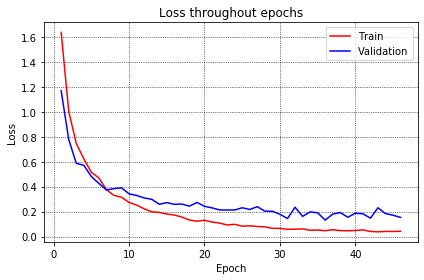

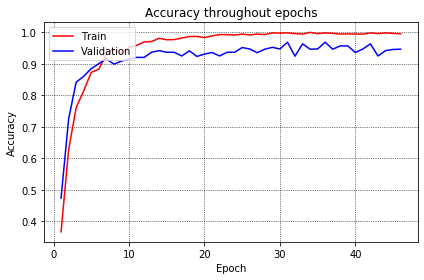

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [28]:
k = main(csv_path_train = csv_path_train, imgs_folder_train = imgs_folder_train, csv_path_test = csv_path_test,
         imgs_folder_test = imgs_folder_test, lr_init = lr_init , batch_size = batch_size, epochs = epochs, 
         early_stop = early_stop, model_name = model_name, weights = weights, pretrained= pretrained, save_folder = save_folder, 
         best_metric = best_metric)